In [128]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from shapely.geometry import box

In [126]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [129]:
df_path = "./predictions/tobii_test_more_layers_weighted_loss_more_patience_more_complex_tune.csv"
df_path_golden = "./golden_test.csv"
user_specs_path = "../data/participant_characteristics.csv"
user_specs = pd.read_csv(user_specs_path)[[
    "Display Height (pixels)", "Display Width (pixels)", 'Participant ID',
    'Screen Width (cm)', 'Screen Height (cm)', 'Distance From Screen (cm)',
    'Self-Reported Vision'
]]
df_pred = pd.read_csv(df_path)
df_pred["distances"] = df_pred[['x_normalized', 'y_normalized', 'pred_x', 'pred_y']].apply(lambda x: distance(*x), axis = 1)
df_pred["user_id"] = df_pred["full_name"].apply(lambda x: x.split("#")[0])
df_pred = df_pred.merge(user_specs, left_on = "user_id", right_on = 'Participant ID', how = "inner", suffixes=["", "_"]).drop(columns = ['Participant ID'])

df_golden = pd.read_csv(df_path_golden)
df_pred_golden = df_golden.merge(df_pred, on = "paths", how = "inner", suffixes=["", "_"])

In [32]:
df_pred.head()

,paths,x_normalized,y_normalized,full_name,pred_x,pred_y,distances,user_id,Display Height (pixels),Display Width (pixels),Screen Width (cm),Screen Height (cm),Distance From Screen (cm),Self-Reported Vision
0,/home/ubuntu/projects/tweakle/data/tobii_image...,0.194715,0.582539,P_38#1492618354027_23_-study-tooth_abscess_wri...,0.299071,0.539524,0.112874,P_38,900,1440,33.17,20.73,50.0,Normal
1,/home/ubuntu/projects/tweakle/data/tobii_image...,0.200532,0.493025,P_38#1492618354027_16_-study-educational_advan...,0.267034,0.464602,0.072321,P_38,900,1440,33.17,20.73,50.0,Normal
2,/home/ubuntu/projects/tweakle/data/tobii_image...,0.247674,0.453015,P_38#1492618354027_24_-study-dot_test_final_in...,0.234997,0.383104,0.071052,P_38,900,1440,33.17,20.73,50.0,Normal
3,/home/ubuntu/projects/tweakle/data/tobii_image...,0.217074,0.442437,P_38#1492618354027_7_-study-benefits_of_runnin...,0.280526,0.475514,0.071556,P_38,900,1440,33.17,20.73,50.0,Normal
4,/home/ubuntu/projects/tweakle/data/tobii_image...,0.123454,0.445198,P_38#1492618354027_9_-study-benefits_of_runnin...,0.180465,0.595299,0.160563,P_38,900,1440,33.17,20.73,50.0,Normal


In [33]:
df_pred["Self-Reported Vision"].value_counts()

Self-Reported Vision
Normal      8078
Glasses     4426
Contacts    1496
Name: count, dtype: int64

In [34]:
def average_angle(df):
    df_ = df.copy()
    df_["x"] = df_["x_normalized"] * df_["Screen Width (cm)"]
    df_["pred_x_"] = df_["pred_x"] * df_["Screen Width (cm)"]
    df_["y"] = df_["y_normalized"] * df_["Screen Height (cm)"]
    df_["pred_y_"] = df_["pred_y"] * df_["Screen Height (cm)"]
    df_["center_y"] = df_["Screen Height (cm)"] * 0.5
    df_["center_x"] = df_["Screen Width (cm)"] * 0.5
    df_["distances_center_pred"] = df_[['center_x', 'center_y', 'pred_x_', 'pred_y_']].apply(lambda x: distance(*x), axis = 1)
    df_["distances_center_gt"] = df_[['center_x', 'center_y', 'x', 'y']].apply(lambda x: distance(*x), axis = 1)
    df_["tg_center_gt"] = df_["distances_center_gt"] / df_["Distance From Screen (cm)"]
    df_["tg_center_pred"] = df_["distances_center_pred"] / df_["Distance From Screen (cm)"]
    df_["angle_gt"] = np.arctan(df_["tg_center_gt"].values) * 180 / np.pi
    df_["angle_pred"] = np.arctan(df_["tg_center_pred"].values) * 180 / np.pi
    angles = (df_["angle_gt"] - df_["angle_pred"]).abs()
    return angles.mean(), angles.std()

In [35]:
def average_pixel_distance(df):
    df_ = df.copy()
    df_["x"] = df_["x_normalized"] * df_["Display Width (pixels)"]
    df_["pred_x_"] = df_["pred_x"] * df_["Display Width (pixels)"]
    df_["y"] = df_["y_normalized"] * df_["Display Height (pixels)"]
    df_["pred_y_"] = df_["pred_y"] * df_["Display Height (pixels)"]
    df_["distances"] = df_[['x', 'y', 'pred_x_', 'pred_y_']].apply(lambda x: distance(*x), axis = 1)
    return df_["distances"].mean(), df_["distances"].std()

In [36]:
def compute_metrics(df):
    preds = df[["pred_x", "pred_y"]].values
    labels = df[["x_normalized", "y_normalized"]].values
    
    mape_value = mape(labels, preds)
    print(f"Test MAPE: {round(mape_value, 4)}")
    
    rmse_value = mse(labels, preds, squared=True)
    print(f"Test RMSE: {round(rmse_value, 4)}")
    
    av_rel_dist = df["distances"].mean()
    print(f"Average relative distance: {round(av_rel_dist, 4)} +- {round(df['distances'].std(), 3)}")

    av_pixel_dist, std = average_pixel_distance(df)
    print(f"Average pixel distance: {round(av_pixel_dist, 1)} +- {round(std, 1)}")
    av_angle, std = average_angle(df)
    print(f"Average angle: {round(av_angle, 2)} +- {round(std, 2)}")

All test

In [37]:
compute_metrics(df_pred)

Test MAPE: 0.4011
Test RMSE: 0.0132
Average relative distance: 0.1235 +- 0.106
Average pixel distance: 175.6 +- 142.9
Average angle: 2.29 +- 2.15


Glasses

In [38]:
df_glasses = df_pred[df_pred['Self-Reported Vision'] == "Glasses"]

In [39]:
compute_metrics(df_glasses)

Test MAPE: 0.4594
Test RMSE: 0.0147
Average relative distance: 0.1319 +- 0.11
Average pixel distance: 186.6 +- 146.5
Average angle: 2.36 +- 2.24


Normal

In [40]:
df_glasses = df_pred[df_pred['Self-Reported Vision'] != "Glasses"]

In [41]:
compute_metrics(df_glasses)

Test MAPE: 0.3741
Test RMSE: 0.0125
Average relative distance: 0.1196 +- 0.103
Average pixel distance: 170.5 +- 140.9
Average angle: 2.26 +- 2.11


Golden test

In [42]:
compute_metrics(df_pred_golden)

Test MAPE: 1.428
Test RMSE: 0.0199
Average relative distance: 0.1687 +- 0.123
Average pixel distance: 173.5 +- 102.5
Average angle: 2.07 +- 2.5


## Metrics on real data

In [44]:
# max_error_x = df["screen_w"].values[0] / width_screen_cm * 2 * np.sqrt(2)
# max_error_y = df["screen_h"].values[0] / height_screen_cm * 2 * np.sqrt(2)
# bbox_size = np.mean([round(max_error_x), round(max_error_y)])
# bbox_size

242.5

In [82]:
def iou(gt_point, point, screen_dims, bbox_size = 242.5):
    x1, y1 = max(point[0] - bbox_size / 2, 0), max(point[1] - bbox_size / 2, 0)
    x2, y2 = min(point[0] + bbox_size / 2, screen_dims[0]), min(point[1] + bbox_size / 2, screen_dims[1])
    box_pred = [x1, y1, x2, y2]
    x1, y1 = max(gt_point[0] - bbox_size / 2, 0), max(gt_point[1] - bbox_size / 2, 0)
    x2, y2 = min(gt_point[0] + bbox_size / 2, screen_dims[0]), min(gt_point[1] + bbox_size / 2, screen_dims[1])
    gt_bbox = [x1, y1, x2, y2]
    box_1 = box(*gt_bbox)
    box_2 = box(*box_pred)
    intersect = box_1.intersection(box_2).area
    union = box_1.union(box_2).area
    if intersect == 0:
        return 0.0
    if (intersect == box_1.area) or (intersect == box_2.area):
        return 1.0
    iou = intersect / union
    return iou

In [83]:
def in_bbox(gt_point, point, screen_dims, bbox_size = 242.5):
    x1, y1 = max(gt_point[0] - bbox_size / 2, 0), max(gt_point[1] - bbox_size / 2, 0)
    x2, y2 = min(gt_point[0] + bbox_size / 2, screen_dims[0]), min(gt_point[1] + bbox_size / 2, screen_dims[1])
    cond1 = x1 <= point[0] <= x2
    cond2 = y1 <= point[1] <= y2
    # print(x1, y1, x2, y2)
    # print(point)
    # print(cond1, cond2)
    return int(cond1 and cond2)

In [130]:
# df = pd.read_csv("./real_experiment/res_calibration_unfreezed_guys_cleaned_weighted_loss_more_compl_3x_val_hard.csv")
df = pd.read_csv("./real_experiment/res_calibration_unfreezed_guys_cleaned_weighted_loss_more_warmup_aug_tune_tune.csv")

In [131]:
x, y = df["pred_x"].values, df["pred_y"].values

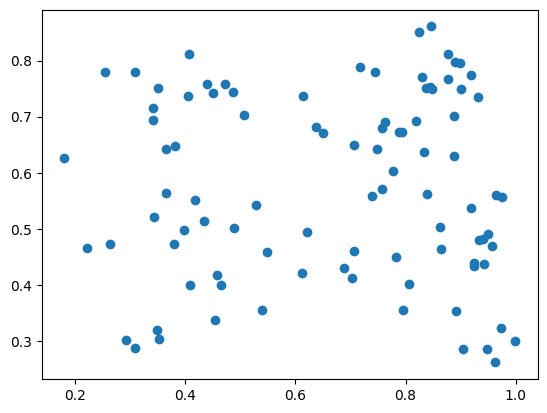

In [132]:
plt.scatter(x, y)
plt.show()

In [133]:
x = np.clip(x, 0, 1)
y = np.clip(y, 0, 1)

In [134]:
min_y = min(y)
min_x = min(x)
max_y = max(y)
max_x = max(x)

In [135]:
x_rescaled_ = (x - min_x) / (max_x - min_x)
y_rescaled_ = (y - min_y) / (max_y - min_y)

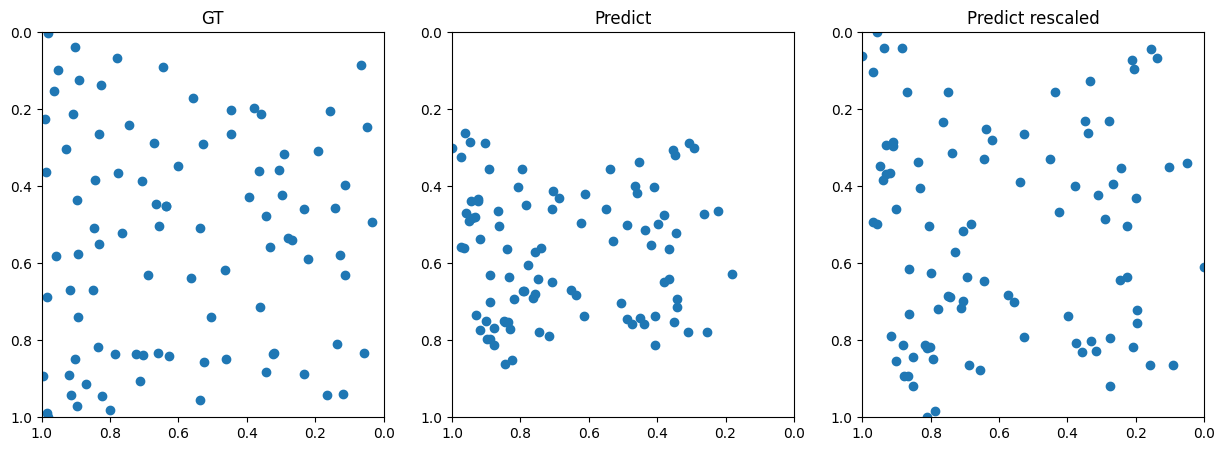

In [136]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("GT")
plt.scatter(df["x_normalized"], df["y_normalized"])
plt.ylim(1, 0)
plt.xlim(1, 0)
plt.subplot(1, 3, 2)
plt.title("Predict")
plt.scatter(x, y)
plt.ylim(1, 0)
plt.xlim(1, 0)
plt.subplot(1, 3, 3)
plt.title("Predict rescaled")
plt.scatter(x_rescaled_, y_rescaled_)
plt.ylim(1, 0)
plt.xlim(1, 0)
plt.show()
plt.show()

In [137]:
df["pred_x_resc"] = x_rescaled_
df["pred_y_resc"] = y_rescaled_

In [138]:
features = df[["pred_x", "pred_y"]].values
labels = df[["x_normalized", "y_normalized"]].values
print("MSE: ", mse(labels, features, squared=False))
print("MSE with rescale: ", mse(labels, df[["pred_x_resc", "pred_y_resc"]].values, squared=False))

MSE:  0.1441873468491098
MSE with rescale:  0.11526554965498012


In [139]:
df["pred_x_abs"] = df["pred_x"] * df["screen_w"]
df["pred_y_abs"] = df["pred_y"] * df["screen_h"]
df["pred_x_abs_resc"] = df["pred_x_resc"] * df["screen_w"]
df["pred_y_abs_resc"] = df["pred_y_resc"] * df["screen_h"]

In [140]:
width_screen_cm, height_screen_cm = 28.5, 18.
df["pred_x_abs_cm"] = df["pred_x"] * width_screen_cm
df["pred_y_abs_cm"] = df["pred_y"] * height_screen_cm
df["pred_x_abs_cm_resc"] = df["pred_x_resc"] * width_screen_cm
df["pred_y_abs_cm_resc"] = df["pred_y_resc"] * height_screen_cm
df["x_gt_cm"] = df["x_normalized"] * width_screen_cm
df["y_gt_cm"] = df["y_normalized"] * height_screen_cm

In [141]:
df["distances"] = df[['x_gt', 'y_gt', 'pred_x_abs', 'pred_y_abs']].apply(lambda x: distance(*x), axis = 1)
df["distances_resc"] = df[['x_gt', 'y_gt', 'pred_x_abs_resc', 'pred_y_abs_resc']].apply(lambda x: distance(*x), axis = 1)
print("Mean and median pixel distance: ", df["distances"].mean(), ", ", df["distances"].median())
print("Mean and median pixel distance with rescale: ", df["distances_resc"].mean(), ", ", df["distances_resc"].median())

Mean and median pixel distance:  361.4818054224444 ,  370.07032872549894
Mean and median pixel distance with rescale:  264.72741071139416 ,  246.43064928644503


In [142]:
df["distances_cm"] = df[['x_gt_cm', 'y_gt_cm', 'pred_x_abs_cm', 'pred_y_abs_cm']].apply(lambda x: distance(*x), axis = 1)
df["distances_cm_resc"] = df[['x_gt_cm', 'y_gt_cm', 'pred_x_abs_cm_resc', 'pred_y_abs_cm_resc']].apply(lambda x: distance(*x), axis = 1)
print("Mean and median cm distance: ", df["distances_cm"].mean(), ", ", df["distances_cm"].median())
print("Mean and median cm distance with rescale: ", df["distances_cm_resc"].mean(), ", ", df["distances_cm_resc"].median())

Mean and median cm distance:  4.218980816723374 ,  4.359138456067395
Mean and median cm distance with rescale:  3.096209025585628 ,  2.848303525280341


In [143]:
df["distances_cm_x"] = df[['x_gt_cm', 'pred_x_abs_cm']].apply(lambda x: np.abs(x[0] - x[1]), axis = 1)
df["distances_cm_y"] = df[['y_gt_cm', 'pred_y_abs_cm']].apply(lambda x: np.abs(x[0] - x[1]), axis = 1)
df["distances_cm_x_resc"] = df[['x_gt_cm', 'pred_x_abs_cm_resc']].apply(lambda x: np.abs(x[0] - x[1]), axis = 1)
df["distances_cm_y_resc"] = df[['y_gt_cm', 'pred_y_abs_cm_resc']].apply(lambda x: np.abs(x[0] - x[1]), axis = 1)
print("Mean x and y cm distance: ", df["distances_cm_x"].mean(), df["distances_cm_y"].mean())
print("Mean x and y cm distance with rescale: ", df["distances_cm_x_resc"].mean(), df["distances_cm_y_resc"].mean())

Mean x and y cm distance:  2.772292267858373 2.6363550268930394
Mean x and y cm distance with rescale:  1.8633039813171222 2.1391572897091726


In [144]:
df["iou"] = df[['x_gt', 'y_gt',
                'pred_x_abs', 'pred_y_abs',
                'screen_w', 'screen_h'
               ]].apply(lambda x: iou(x[:2].values, x[2:4].values, x[4:].values), axis = 1)
df["iou_resc"] = df[['x_gt', 'y_gt',
                'pred_x_abs_resc', 'pred_y_abs_resc',
                'screen_w', 'screen_h'
               ]].apply(lambda x: iou(x[:2].values, x[2:4].values, x[4:].values), axis = 1)
print("IOU: ", df["iou"].mean())
print("IOU with rescale: ", df["iou_resc"].mean())

IOU:  0.048230425277013815
IOU with rescale:  0.1218888884464379


/opt/tensorflow/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/tensorflow/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [122]:
df["in_bbox"] = df[['x_gt', 'y_gt',
                'pred_x_abs', 'pred_y_abs',
                'screen_w', 'screen_h'
               ]].apply(lambda x: in_bbox(x[:2].values, x[2:4].values, x[4:].values), axis = 1)
df["in_bbox_resc"] = df[['x_gt', 'y_gt',
                'pred_x_abs_resc', 'pred_y_abs_resc',
                'screen_w', 'screen_h'
               ]].apply(lambda x: in_bbox(x[:2].values, x[2:4].values, x[4:].values), axis = 1)
print("Ratio in bbox: ", df["in_bbox"].mean())
print("Ratio in bbox with rescale: ", df["in_bbox_resc"].mean())

Ratio in bbox:  0.07526881720430108
Ratio in bbox with rescale:  0.20430107526881722


In [123]:
df.sort_values("distances")[[
    'x_gt', 'y_gt', 'pred_x_abs',
    'pred_y_abs', 'pred_x_abs_resc', 'pred_y_abs_resc', 'distances', 'distances_cm','distances_resc', 'distances_cm_resc',
    'iou', 'iou_resc', 'in_bbox', 'in_bbox_resc'
]].tail(40)

,x_gt,y_gt,pred_x_abs,pred_y_abs,pred_x_abs_resc,pred_y_abs_resc,distances,distances_cm,distances_resc,distances_cm_resc,iou,iou_resc,in_bbox,in_bbox_resc
55,1660,439,1971.351730,625.230811,1883.778450,443.508249,362.797209,4.210479,223.823857,2.578437,0.0,0.039375,0,0
68,1983,1490,1806.368933,1168.975669,1689.767030,1337.436943,366.408454,4.311893,330.546610,3.830776,0.0,0.000000,0,0
50,2431,1519,2311.648302,1167.470717,2283.949998,1334.962768,371.238016,4.384024,235.570384,2.760313,0.0,0.076123,0,0
66,2217,1477,2099.872962,1122.976076,2034.912915,1261.812585,372.896342,4.404166,281.888862,3.300553,0.0,0.017013,0,0
16,849,724,765.888006,1092.447818,466.214114,1211.623447,377.705439,4.467010,619.920689,7.265635,0.0,0.000000,0,0
53,85,749,458.452462,689.273974,104.685473,548.796640,378.198281,4.359852,201.168842,2.381650,0.0,0.090795,0,0
83,825,848,1186.938115,728.863590,961.347735,613.882853,381.041577,4.401682,270.927192,3.186459,0.0,0.007624,0,0
14,1380,260,1479.320878,631.172856,1305.175068,453.277103,384.231604,4.541942,207.255420,2.445737,0.0,0.075471,0,0
71,1576,684,1892.949433,902.202992,1791.581316,898.856702,384.797984,4.473053,304.366073,3.555460,0.0,0.006367,0,0
25,1246,1124,1617.760475,1014.539139,1467.973028,1083.539838,387.540360,4.474482,225.630339,2.601588,0.0,0.036551,0,0


In [124]:
print("Ratio samples OK: ", df[df["distances_cm"] <= 2].shape[0] / df.shape[0])
print("Ratio samples OK with rescale: ", df[df["distances_cm_resc"] <= 2].shape[0] / df.shape[0])

Ratio samples OK:  0.12903225806451613
Ratio samples OK with rescale:  0.3118279569892473


In [102]:
print("Ratio samples almost OK: ", df[df["distances_cm"] <= 3].shape[0] / df.shape[0])
print("Ratio samples almost OK with rescale: ", df[df["distances_cm_resc"] <= 3].shape[0] / df.shape[0])

Ratio samples almost OK:  0.3010752688172043
Ratio samples almost OK with rescale:  0.5376344086021505
